In [31]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from get_bounds import *
from plotting_utility import *
from exportToJSON import *
from system_scoring import *

### Grid Points Load (output from scoring.ipynb)
Grid Points are now scored in `scoring.ipynb`.

In [32]:
STD_DEV = 0.9
YYZ_GridPoints = pd.read_csv('../res/grid_points/yvr_grid_points_' + str(STD_DEV) + '.csv', sep = ',')
PT_DENSITY = len(YYZ_GridPoints["lat"].unique())

### Clustered Grid Points Load (output from clustering.ipynb)
Clustered Grid Points (a subset of Grid Points) are now scored in `clustering.ipynb`.

In [33]:
MAX_CLUSTER_SIZE = 10
YYZ_Clustered_GridPoints = []
for c in range(1, MAX_CLUSTER_SIZE + 1):
   YYZ_Clustered_GridPoints.append(pd.read_csv('../res/grid_points/yvr_clustered_grid_points_' + str(STD_DEV) + '_' + str(c) + '.csv', sep = ','))
#NUM_CLUSTERS = len(YYZ_Clustered_GridPoints[0]["cluster"].unique())

### Parameters

In [34]:
INTERCHANGE_CANDIDATE_BONUS_FACTOR = 5
INTERCHANGE_CANDIDATE_BONUS_DECAY = 2
POLY_REGRESSION_ORDER = 5
NUMBER_INTERCHANGE_CANDIDATES = 2
STATION_MIN_DISTANCE = 0.9
INTERCHANGE_MIN_DISTANCE = 3
MAX_SCORING_DISTANCE = 2
LINE_PT_THRESHOLD = 1

### Regression

In [35]:
def linearRegression(scores):
    # step 1: don't use points that are very small (threshold)
    threshold = statistics.median(scores['score'])
    thresholded_scores = scores.loc[scores['score'] >= threshold]
    #print(thresholded_scores)

    regr = LinearRegression()
    lats = thresholded_scores["lat"].values.reshape(-1, 1)
    longs = thresholded_scores["long"].values.reshape(-1, 1)
    regr.fit(lats, longs, thresholded_scores["score"]) # Score is Squared because sample_weight is square rooted thresholded_scores["score"]
    x_begin = lats[0]
    x_end = lats[-1]
    y_begin = regr.predict(x_begin.reshape(1, -1)).item()
    y_end = regr.predict(x_end.reshape(1, -1)).item()

    return (x_begin.item(), x_end.item(), y_begin, y_end)

In [36]:
def polynomialRegression(scores, degree, upperLatBound, bottomLatBound):
    poly = PolynomialFeatures(degree, include_bias=False)
    poly_features = poly.fit_transform(scores["lat"].values.reshape(-1, 1))
    poly_reg_model = LinearRegression().fit(poly_features, scores["long"], scores["score"])
    # = scores['lat'].unique()
    x = np.linspace(scores['lat'].min(), scores['lat'].max(), PT_DENSITY)
    #x = np.arange(bottomLatBound, upperLatBound, round((upperLatBound-bottomLatBound)/PT_DENSITY, 4))
    y = poly_reg_model.predict(poly.fit_transform(x.reshape(-1, 1)))
    return (x, y, poly_reg_model.intercept_, poly_reg_model.coef_)

In [37]:
def getLine(scores, upper, bottom, left, right):
    [*line, line_intercept, line_coefficients] = polynomialRegression(scores, POLY_REGRESSION_ORDER, upper, bottom)
    line = trimOutOfBounds(line, upper, bottom, left, right)
    line = snapLongToGrid(line, left, right, PT_DENSITY)
    return (line, line_intercept, line_coefficients)

### Query Functions

In [38]:
# Gets the points associated with the n highest scores of the line, separated by at least dist
# Does not guarantee that n highest scores will be returned, if restricted by dist. Guarantees at MOST n scores returned.
def getHighestNScorePointsWithMinDist(pts, n, dist, exclusions=pd.DataFrame()):
    sortedPoints = pts.sort_values(by=['score'], ascending=False)
    highestPoints = pd.DataFrame()

    for idx, p in sortedPoints.iterrows():
        if len(highestPoints) >= n:
            break

        previousPoint = (highestPoints.iloc[-1]["lat"], highestPoints.iloc[-1]["long"]) if len(highestPoints) > 0 else (-90,-90)
        currentPoint = (p["lat"], p["long"])
        delta = getDistance(previousPoint, currentPoint)

        if delta >= dist:
            flag = False
            for excIdx, excPoint in exclusions.iterrows():
                if (getDistance((excPoint["lat"], excPoint["long"]), currentPoint) < dist):
                    flag = True
                    break
            if (not flag):
                highestPoints = highestPoints.append(p)

    return highestPoints

In [39]:
def getGridPointsFromLine(scores, line):
    numPoints = len(line[0])
    lineGridPoints = pd.DataFrame()

    for index in range(0, numPoints):
        lati = line[0][index]
        longi = line[1][index]

        scoreIndex = scores.loc[(abs(scores["lat"] - lati) <= 0.005) & (abs(scores["long"] - longi) <= 0.005)].index.values
        if len(scoreIndex) > 0:
            lineGridPoints = lineGridPoints.append(scores.iloc[scoreIndex[0]])

    return lineGridPoints

### Line Generation

In [40]:
# This function generates the lines for the system, and returns the lines in [[lats], [longs]] format
# Also returns the interchange candidates (what possibly can be an interchange) as an array of DataFrames
def generateLines(gridPoints, clusterGridPointsArray, upperBound, bottomBound, leftBound, rightBound, NUM_CLUSTERS):
    lines = []
    interchangeCandidates = pd.DataFrame()
    for i in range(NUM_CLUSTERS):
        clusterGridPointsArray[i] = clusterGridPointsArray[i].append(interchangeCandidates)

        # Decay previous interchange Candidates
        if len(interchangeCandidates) > 0:
            interchangeCandidates['score'] = interchangeCandidates['score'].div(INTERCHANGE_CANDIDATE_BONUS_DECAY)

        [line, _, _] = getLine(clusterGridPointsArray[i], upperBound, bottomBound, leftBound, rightBound)
        lines.append(line)
        linePoints = getGridPointsFromLine(gridPoints, line)
        highestPoints = getHighestNScorePointsWithMinDist(linePoints, NUMBER_INTERCHANGE_CANDIDATES, INTERCHANGE_MIN_DISTANCE, interchangeCandidates)
        if len(highestPoints) > 0:
            highestPoints = highestPoints.assign(score=highestPoints['score'] * INTERCHANGE_CANDIDATE_BONUS_FACTOR)
            interchangeCandidates = interchangeCandidates.append(highestPoints)

        # Code to plot how the subway system is built
        #interchangeCandidatePoints = [(interchangeCandidates["lat"].to_numpy(), interchangeCandidates["long"].to_numpy())]
        #plotHeatmapPoints(gridPoints, lines + interchangeCandidatePoints, PT_DENSITY)
    return (lines, interchangeCandidates)

In [41]:
def splitGridPointsByClusters(gridPointsWithCluster, NUM_CLUSTERS):
    gridPointClusterArray = []
    for i in range(NUM_CLUSTERS):
        gridPointClusterArray.append(gridPointsWithCluster.loc[gridPointsWithCluster['cluster'] == i])
    return gridPointClusterArray

In [42]:
def removeEmptyPoints(lines, gridPoints):
    newLines = []

    gp = list(zip(list(gridPoints["lat"]), list(gridPoints["long"]), list(gridPoints["score"])))

    for line in lines:
        keptStationsLat = np.empty(0)
        keptStationsLong = np.empty(0)
        for station in zip(line[0], line[1]):
            includedScores = 0
            for point in gp:
                if distance((point[0], point[1]), station) < MAX_SCORING_DISTANCE:
                    includedScores += point[2]
            if (includedScores >= LINE_PT_THRESHOLD):
                keptStationsLat = np.append(keptStationsLat, station[0])
                keptStationsLong = np.append(keptStationsLong, station[1])
        newLines.append((keptStationsLat, keptStationsLong))
    return newLines

### Station Generation

In [43]:
# This function generates the stations for a line and returns them in an array
#line numbers are 0 indexed
#distance in km
def generateStationsOnLine(statDistance, subwayLines, lineNum):
    stations = []
    size = len(subwayLines[lineNum][0])

    lati = subwayLines[lineNum][0][0]
    longi = subwayLines[lineNum][1][0]

    stationCor = (lati, longi)
    placeStation = stationCor

    d = {'lat': [lati], 'long': [longi]}
    df = pd.DataFrame(data=d)

    for index in range(0, size - 1):

        lati2 = subwayLines[lineNum][0][index + 1]
        longi2 = subwayLines[lineNum][1][index + 1]

        nextStation = (lati2, longi2)

        distance = getDistance(nextStation, placeStation)

        if distance >= statDistance:

            new_row = {'lat': lati2, 'long': longi2}
            df = df.append(new_row, ignore_index=True)

            placeStation = nextStation


    #convert data frame to numpy array to append to list so we can plot
    lineStat = (df['lat'].values, df['long'].values)

    stations.append(lineStat)

    #return the new set of points
    return stations

In [44]:
#lineNum is not 0 indexed
def generateStationsInSystem(lines, statDistance, NUM_CLUSTERS):
    stationsInSystem = []
    for idx in range(0, NUM_CLUSTERS):
        stationsInSystem += generateStationsOnLine(statDistance,lines, idx)
    return stationsInSystem

### Toronto (YYZ)

In [45]:
[YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound] = getBounds(YYZ_GridPoints['lat'], YYZ_GridPoints['long'], 4)

In [46]:
# YYZ_Cluster_GP_Array is an array with each line being its own cluster's grid points
YYZ_Cluster_GP_Array = []
for c in range(0, MAX_CLUSTER_SIZE):
    YYZ_Cluster_GP_Array.append(splitGridPointsByClusters(YYZ_Clustered_GridPoints[c], c + 1))

In [47]:
YYZ_Lines = []
YYZ_Interchange_Candidates = []
for c in range(0, MAX_CLUSTER_SIZE):
    lines, interchangeCandidates = generateLines(
        YYZ_GridPoints, YYZ_Cluster_GP_Array[c], YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound, c + 1
    )
    YYZ_Lines.append(lines)
    YYZ_Interchange_Candidates.append(interchangeCandidates)

<AxesSubplot:xlabel='lat', ylabel='long'>

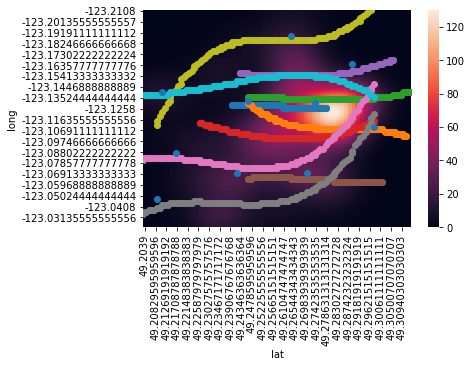

In [48]:
# Draw the System
interchangeCandidatePoints = [(YYZ_Interchange_Candidates[MAX_CLUSTER_SIZE - 1]["lat"].to_numpy(), YYZ_Interchange_Candidates[MAX_CLUSTER_SIZE - 1]["long"].to_numpy())]
plotHeatmapPoints(YYZ_GridPoints, YYZ_Lines[MAX_CLUSTER_SIZE - 1] + interchangeCandidatePoints, PT_DENSITY)

In [49]:
YYZ_Cleaned_Lines = []
for c in range(0, MAX_CLUSTER_SIZE):
    YYZ_Cleaned_Lines.append(removeEmptyPoints(YYZ_Lines[c], YYZ_GridPoints))

In [50]:
YYZ_Stations = []
for c in range(0, MAX_CLUSTER_SIZE):
    YYZ_Stations.append(generateStationsInSystem(YYZ_Cleaned_Lines[c], STATION_MIN_DISTANCE, c + 1))

<AxesSubplot:xlabel='lat', ylabel='long'>

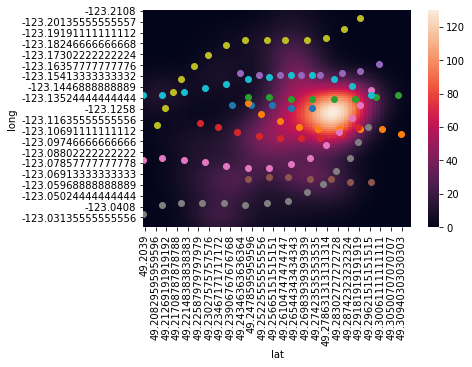

In [51]:
plotHeatmapPoints(YYZ_GridPoints, YYZ_Stations[MAX_CLUSTER_SIZE - 1], PT_DENSITY)

### Export Cells

In [52]:
YYZ_Custom_Colors = [
    "#ffcc33", #line 1 color
    '#009966', #line 2 color
    '#0099cc', #line 3 color
    '#993366',
    '#ff6600',
    '#999999',
    '#99cc99',
    '#ff6699',
    '#cc0000',
    '#663300'
]

In [53]:
for c in range(0, MAX_CLUSTER_SIZE):
    exportToJSON(YYZ_Cleaned_Lines[c], YYZ_Stations[c], "yvr_" + str(c + 1), YYZ_Custom_Colors)

In [ ]:
#definitely a better way to do this
numStations = 0
for line in YYZ_Stations:
    for station in zip(line[0], line[1]):
        numStations += 1

numStations

In [ ]:
scoreSystem(YYZ_GridPoints, YYZ_Stations)